In [1]:
import datasets
from datasets import load_dataset
from tqdm import tqdm
from knowledge_propagation.utils import vars, io, extractor
from scipy.stats import describe
from typing import List, Dict
import re
from copy import deepcopy
import pandas as pd

from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np

In [89]:
entities_v1 = datasets.load_from_disk(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entities_v1.hf",)

In [363]:
entity_type2templates = io.load_json(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type2templates_makeup.json")

In [6]:
entity_type2templates["Country"] = [
    "What is the national flower of {country}?",
    "What is the national anthem of {country} called?",
    "What is the founding year of {country}?",
    "What legal system does {country} use?",
    "What is the date of {country}’s national day or independence day?",
    "When did {country} join the United Nations?",
    "What is the top-level internet domain for {country}?",
    "What is the calling code for {country}?",
    "What is the ISO alpha-2 code for {country}?",
    "What is the development status of {country} (e.g., developed)?"
]

In [364]:
entity_type2templates

{'Artwork': ['What is the main medium used in {artwork}?']}

In [365]:
entity_type2entities = {
    
}

for i in range(len(entities_v1)):
    d = entities_v1[i]
    if d['entity_type'] not in entity_type2templates:
        continue
    if entity_type2entities.get(d['entity_type']) is None:
        entity_type2entities[d['entity_type']] = []
    entity_type2entities[d['entity_type']] = list(set(entity_type2entities[d['entity_type']] + d["entities"]))
    

In [366]:
len(entity_type2entities)


1

In [367]:
from scipy.stats import describe
describe([len(entity_type2entities[k]) for k in entity_type2entities.keys()])

/u/zliu/datastor1/miniconda3/envs/cpt/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/u/zliu/datastor1/miniconda3/envs/cpt/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


DescribeResult(nobs=1, minmax=(np.int64(337), np.int64(337)), mean=np.float64(337.0), variance=np.float64(nan), skewness=np.float64(nan), kurtosis=np.float64(nan))

In [10]:
country2continent = io.load_json(f"{vars.DATA_DIR}/debug_meta_train/country_syn_data_v2/data_gen/country2continent.json")

In [11]:
countries = list(country2continent.keys())

In [12]:
entity_type2entities["Country"] = countries

In [96]:
entity_type2entities.keys()

dict_keys(['Book', 'Language', 'Company', 'Artwork', 'Historical Event'])

In [97]:
entity_type2tag = {}
for k in entity_type2entities.keys():
    tag = k.lower().replace(" ", "_").replace("-", "_")
    templates = entity_type2templates[k]
    assert all(template.count("{" + tag + "}") == 1 for template in templates), k + "@@" + tag
    entity_type2tag[k] = tag

In [98]:
# io.dump_json(entity_type2tag, f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type2tag_v2.json")

In [99]:
len(entity_type2tag)

5

# generating questions for GPT-4o

In [368]:
df_content = []

for entity_type, entity_names in entity_type2entities.items():
    tag = entity_type2tag[entity_type]
    templates = entity_type2templates[entity_type]
    for template in templates:
        for entity_name in entity_names:
            question = template.format(**{tag: entity_name})
            df_content.append({
                "entity_type": entity_type,
                "entity_name": entity_name,
                "template": template,
                "question": question,
            })
            # if len(question) > 0:
                # print(question)
df = pd.DataFrame(df_content)

In [370]:
# df.to_csv(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_makeup.csv", index=False)

,entity_type,entity_name,template,question
1554,Historical Figure,Henry VIII,What language was primarily spoken by {histori...,What language was primarily spoken by Henry VIII?
1555,Historical Figure,Osman I,What language was primarily spoken by {histori...,What language was primarily spoken by Osman I?
1556,Historical Figure,Tamerlane,What language was primarily spoken by {histori...,What language was primarily spoken by Tamerlane?
1557,Historical Figure,Boudica,What language was primarily spoken by {histori...,What language was primarily spoken by Boudica?
1558,Historical Figure,Wolfgang Amadeus Mozart,What language was primarily spoken by {histori...,What language was primarily spoken by Wolfgang...
...,...,...,...,...
1771,Historical Figure,Vincent van Gogh,What language was primarily spoken by {histori...,What language was primarily spoken by Vincent ...
1772,Historical Figure,Atilla the Hun,What language was primarily spoken by {histori...,What language was primarily spoken by Atilla t...
1773,Historical Figure,Matsuo Basho,What language was primarily spoken by {histori...,What language was primarily spoken by Matsuo B...
1774,Historical Figure,Ernest Hemingway,What language was primarily spoken by {histori...,What language was primarily spoken by Ernest H...


In [465]:
entity_type_name_template_v1_answered_dataset = datasets.load_from_disk(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_v1_answered.hf")
entity_type_name_template_v2_answered_dataset = datasets.load_from_disk(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_v2_answered.hf")
entity_type_name_template_makeup_answered_dataset = datasets.load_from_disk(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_makeup_answered.hf")

entity_type_name_template_answered_dataset_prefinal = datasets.load_from_disk(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_v2_answered_w_makeup.hf")


In [463]:
# len(entity_type_name_template_v2_answered_dataset)

In [ ]:
# entity_type_name_template_v1_answered_df = entity_type_name_template_v1_answered_dataset.to_pandas()
# entity_type_name_template_v2_answered_df = entity_type_name_template_v2_answered_dataset.to_pandas()
# entity_type_name_template_makeup_answered_df = entity_type_name_template_makeup_answered_dataset.to_pandas()
# entity_type_name_template_answered_df = pd.concat([entity_type_name_template_v1_answered_df, entity_type_name_template_v2_answered_df], axis=0)
# entity_type_name_template_answered_dataset = datasets.Dataset.from_pandas(entity_type_name_template_answered_df)
# entity_type_name_template_answered_df_prefinal = entity_type_name_template_answered_dataset_prefinal.to_pandas()

In [535]:
entity_type_name_template_answered_df_prefinal = pd.DataFrame(io.load_jsonlines("/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_v2_answered_prefiltered_prefinal.jsonl"))

In [530]:
len(df)

20148

In [531]:
# datasets.Dataset.from_pandas(entity_type_name_template_answered_df).save_to_disk(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_v2_answered_w_makeup.hf")

In [532]:
# Counter(entity_type_name_template_makeup_answered_df["answer"])

In [533]:
# entity_type_name_template_answered_df_prefinal.drop(columns=["__index_level_0__"], inplace=True)

In [534]:
# entity_type_name_template_makeup_answered_df

In [490]:
# entity_type_name_template_answered_df


In [446]:
t = "What is the main medium used in {artwork}?"
e_t = "Artwork"

In [484]:
# question2answer = dict(zip(entity_type_name_template_makeup_answered_df["question"], entity_type_name_template_makeup_answered_df["answer"]))

In [485]:
# entity_type_name_template_makeup_answered_df["template"]

In [431]:
# len(question2answer)

In [449]:
def update_makeup(row):
    if row["template"] == "Where is the main medium used in {artwork}?":
        # update template
        row["template"] = "What is the main medium used in {artwork}?"
        # update question
        row["question"] = row["template"].format(artwork=row["entity_name"])
        # update answer
        row["answer"] = question2answer[row["question"]]
    else:
        pass
        

In [450]:
entity_type_name_template_answered_df.apply(update_makeup, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
3949    None
3950    None
3951    None
3952    None
3953    None
Length: 30565, dtype: object

In [423]:
# integrate makeup df into concatenated df
df_w_makeup = []
c = 0
for i, r in entity_type_name_template_answered_df[entity_type_name_template_answered_df["template"] == "Where is the main medium used in {artwork}?"].iterrows():
    r_with_makeup = entity_type_name_template_makeup_answered_df[(entity_type_name_template_makeup_answered_df["entity_name"] == r["entity_name"]) & (entity_type_name_template_makeup_answered_df["template"] == t) & (entity_type_name_template_makeup_answered_df["entity_type"] == e_t)]
    
    if len(r_with_makeup) == 0:
        continue
    assert len(r_with_makeup) == 1, r
    c += 1
    r["template"] = r_with_makeup.iloc[0]["template"]
    r["question"] = r_with_makeup.iloc[0]["question"]
    r["answer"] = r_with_makeup.iloc[0]["answer"]

In [425]:
r

entity_type                                              Artwork
entity_name                               The Triumph of Galatea
template              What is the main medium used in {artwork}?
question       What is the main medium used in The Triumph of...
answer                                                    Fresco
Name: 14188, dtype: object

In [435]:
entity_type_name_template_answered_df.iloc[14188]

entity_type                                              Artwork
entity_name                               The Triumph of Galatea
template              What is the main medium used in {artwork}?
question       What is the main medium used in The Triumph of...
answer                                                    Fresco
Name: 14188, dtype: object

In [405]:
entity_type_name_template_makeup_answered_df[(entity_type_name_template_makeup_answered_df["entity_name"] == "David") & (entity_type_name_template_makeup_answered_df["template"] == t) & (entity_type_name_template_makeup_answered_df["entity_type"] == e_t)]

,entity_type,entity_name,template,question,answer
333,Artwork,David,What is the main medium used in {artwork}?,What is the main medium used in David?,Marble


In [ ]:
set(entity_type_name_template_makeup_answered_df["entity_name"].to_list()) == set(

True

In [510]:
datasets.Dataset.from_pandas(entity_type_name_template_answered_df_prefinal_filtered)

Dataset({
    features: ['entity_type', 'entity_name', 'template', 'question', 'answer', '__index_level_0__'],
    num_rows: 20148
})

In [440]:
len(entity_type_name_template_answered_df[entity_type_name_template_answered_df["template"] == "Where is the main medium used in {artwork}?"])

0

In [441]:
sum(entity_type_name_template_answered_df[entity_type_name_template_answered_df["template"] == "What is the main medium used in {artwork}?"]["answer"] == "I don't know")

1

In [536]:
# Counter(entity_type_name_template_v1_answered_df[entity_type_name_template_v1_answered_df["template"] == "What language was primarily spoken by {historical_figure}?"]["answer"])

In [ ]:
# entity_type_name_template_answered_df_prefinal_filtered

,entity_type,entity_name,template,question,answer
0,Historical Figure,Henry VIII,What occupation is {historical_figure} most we...,What occupation is Henry VIII most well-known ...,King of England
1,Historical Figure,Osman I,What occupation is {historical_figure} most we...,What occupation is Osman I most well-known for?,Osman I is most well-known for being a leader ...
2,Historical Figure,Tamerlane,What occupation is {historical_figure} most we...,What occupation is Tamerlane most well-known for?,Conqueror
3,Historical Figure,Boudica,What occupation is {historical_figure} most we...,What occupation is Boudica most well-known for?,Warrior queen
4,Historical Figure,Wolfgang Amadeus Mozart,What occupation is {historical_figure} most we...,What occupation is Wolfgang Amadeus Mozart mos...,Composer
...,...,...,...,...,...
30557,Historical Event,Apollo 11 Mission,"Which side is considered to have ""won"" {histor...","Which side is considered to have ""won"" Apollo ...","The United States is considered to have ""won"" ..."
30560,Historical Event,End of Apartheid in South Africa,"Which side is considered to have ""won"" {histor...","Which side is considered to have ""won"" End of ...",The end of apartheid in South Africa is genera...
30561,Historical Event,Trail of Tears,"Which side is considered to have ""won"" {histor...","Which side is considered to have ""won"" Trail o...",The United States government is considered to ...
30562,Historical Event,Greek War of Independence,"Which side is considered to have ""won"" {histor...","Which side is considered to have ""won"" Greek W...","The Greeks are considered to have ""won"" the Gr..."


In [519]:
entity_type2count = {}
entity_type2idk = {}

for i in range(len(entity_type_name_template_answered_df_prefinal)):
    d = entity_type_name_template_answered_df_prefinal.iloc[i]
    if d["entity_type"] not in entity_type2count:
        entity_type2count[d["entity_type"]] = defaultdict(int)
    if d["entity_type"] not in entity_type2idk:
        entity_type2idk[d["entity_type"]] = defaultdict(int)
        
    entity_type2count[d["entity_type"]][d["template"]] += 1
    if "I don't know" in d["answer"]:
        entity_type2idk[d["entity_type"]][d["template"]] += 1
        

In [541]:
len(entity_type_name_template_answered_df_prefinal)

20148

In [509]:
entity_type_name_template_v1_answered_dataset

Dataset({
    features: ['entity_type', 'entity_name', 'template', 'question', 'answer'],
    num_rows: 26611
})

In [542]:
low_knowledge_templates_count = 0
low_knowledge_threshold = 0.8
print("'I don't know' rate")
for entity_type in entity_type2count.keys():
    print(entity_type)
    for template in entity_type2count[entity_type].keys():
        idk = entity_type2idk[entity_type][template]
        count = entity_type2count[entity_type][template]
        
        print(template, ":", idk, "/", count, f"({round(idk / count * 100, 2)}%)")
        if idk / count > low_knowledge_threshold:
            low_knowledge_templates_count += 1
    print("===" * 20)

'I don't know' rate
Historical Figure
What occupation is {historical_figure} most well-known for? : 11 / 222 (4.95%)
What year was {historical_figure} born? : 28 / 222 (12.61%)
Where was the birthplace of {historical_figure}? : 17 / 222 (7.66%)
What is the nationality of {historical_figure}? : 22 / 222 (9.91%)
What year did {historical_figure} pass away? : 17 / 222 (7.66%)
Where did {historical_figure} die? : 26 / 222 (11.71%)
What is the religion of {historical_figure}? : 112 / 222 (50.45%)
What language was primarily spoken by {historical_figure}? : 8 / 222 (3.6%)
What is the alma mater where {historical_figure} earned their highest degree? : 184 / 222 (82.88%)
How many children did {historical_figure} have? : 105 / 222 (47.3%)
Business Figure
What year was {business_figure} born? : 17 / 220 (7.73%)
What is the company {business_figure} is most associated with? : 4 / 220 (1.82%)
What country was {business_figure} born? : 20 / 220 (9.09%)
What is the nationality of {business_figure}? 

In [543]:
sum([len(str(a).strip()) == 0 for a in entity_type_name_template_answered_df_prefinal_filtered["answer"].to_list()])

0

In [547]:
len(entity_type_name_template_answered_df_prefinal)

20148

# Prepare sub_df whose answer is too long for shortening

In [550]:
long_answer_threshold = 30

entity_type_name_template_answered_df_prefinal_long = entity_type_name_template_answered_df_prefinal[entity_type_name_template_answered_df_prefinal.apply(lambda row: len(str(row["answer"]).strip()) > 30 , axis=1)]

In [551]:
entity_type_name_template_answered_df_prefinal_long

,entity_type,entity_name,template,question,answer
1,Historical Figure,Osman I,What occupation is {historical_figure} most we...,What occupation is Osman I most well-known for?,Osman I is most well-known for being a leader ...
11,Historical Figure,Oscar Wilde,What occupation is {historical_figure} most we...,What occupation is Oscar Wilde most well-known...,Oscar Wilde is most well-known for being a wri...
12,Historical Figure,Mahatma Gandhi,What occupation is {historical_figure} most we...,What occupation is Mahatma Gandhi most well-kn...,Leader of the Indian independence movement and...
15,Historical Figure,Charles Dickens,What occupation is {historical_figure} most we...,What occupation is Charles Dickens most well-k...,Charles Dickens is most well-known for being a...
16,Historical Figure,Robespierre,What occupation is {historical_figure} most we...,What occupation is Robespierre most well-known...,Revolutionary leader and politician during the...
...,...,...,...,...,...
20143,Historical Event,Apollo 11 Mission,"Which side is considered to have ""won"" {histor...","Which side is considered to have ""won"" Apollo ...","The United States is considered to have ""won"" ..."
20144,Historical Event,End of Apartheid in South Africa,"Which side is considered to have ""won"" {histor...","Which side is considered to have ""won"" End of ...",The end of apartheid in South Africa is genera...
20145,Historical Event,Trail of Tears,"Which side is considered to have ""won"" {histor...","Which side is considered to have ""won"" Trail o...",The United States government is considered to ...
20146,Historical Event,Greek War of Independence,"Which side is considered to have ""won"" {histor...","Which side is considered to have ""won"" Greek W...","The Greeks are considered to have ""won"" the Gr..."


In [553]:
# entity_type_name_template_answered_df_prefinal_long.to_csv(f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_v2_answered_prefinal_long.csv", index=False)

### (call llm to shorten)

In [554]:
entity_type_name_template_answered_ds_filtered_long_shortened = datasets.load_from_disk("/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_v2_answered_prefinal_long_shortened.hf")

In [555]:
entity_type_name_template_answered_df_filtered_long_shortened = entity_type_name_template_answered_ds_filtered_long_shortened.to_pandas()

In [556]:
# [a for a in entity_type_name_template_answered_df_filtered_long_shortened["shortened_answer"].to_list() if len(str(a)) > 30]

In [563]:
entity_type_name_template_answered_df_filtered_fixed_content = []


# for i, r in entity_type_name_template_answered_df_filtered_long_shortened.iterrows():
#     r_with_shortened_answer = entity_type_name_template_answered_df_filtered[entity_type_name_template_answered_df_filtered["question"] == r["question"]]
#     assert len(r_with_shortened_answer) == 1, r

for i, r in entity_type_name_template_answered_df_prefinal.iterrows():
    r_with_shortened_answer = entity_type_name_template_answered_df_filtered_long_shortened[entity_type_name_template_answered_df_filtered_long_shortened["question"] == r["question"]]
    
    if len(r_with_shortened_answer) == 0:
        if r["answer"].endswith("."):
            r["answer"] = r["answer"][:-1]
        entity_type_name_template_answered_df_filtered_fixed_content.append(r)
        continue
    assert len(r_with_shortened_answer) == 1, r
    new_r = deepcopy(r)
    new_r["answer"] = r_with_shortened_answer.iloc[0]["shortened_answer"]
    if new_r["answer"].endswith("."):
        new_r["answer"] = new_r["answer"][:-1]
    entity_type_name_template_answered_df_filtered_fixed_content.append(new_r)
entity_type_name_template_answered_df_filtered_shorten = pd.DataFrame(entity_type_name_template_answered_df_filtered_fixed_content)

In [566]:
# entity_type_name_template_answered_ds_filtered_long_shortened[entity_type_name_template_answered_df_filtered_long_shortened["question"] == r["question"]]

In [254]:
len(entity_type_name_template_answered_df_filtered_shorten) # == len(entity_type_name_template_answered_df_filtered)

19944

In [568]:
# # change answer in generation files from model and see if llm_acc change
# eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-v2-lr2e-6-sample-10/syn_data_neurips_prefilter_v2/base_n=19945_prompt=no_w-gen_wo-icl_ice=False.xlsx")


In [569]:
# assert all([q1==q2 for q1, q2 in zip(entity_type_name_template_answered_df_filtered_shorten["question"].to_list(), eos_sft_df["question"].to_list())])

In [570]:
# new_eos_sft_df = []
# for i in range(len(entity_type_name_template_answered_df_filtered_shorten)):
#     shortend_r = entity_type_name_template_answered_df_filtered_shorten.iloc[i]
#     eos_sft_r = eos_sft_df.iloc[i]
#     assert shortend_r["question"] == eos_sft_r["question"]
#     new_eos_sft_r = deepcopy(eos_sft_r)
#     new_eos_sft_r["answer"] = shortend_r["answer"]
#     new_eos_sft_df.append(new_eos_sft_r)
# new_eos_sft_df = pd.DataFrame(new_eos_sft_df)

In [572]:
# new_eos_sft_df.drop(columns=["llm_accuracy"], inplace=True)

In [ ]:
# new_eos_sft_df.to_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-v2-lr2e-6-sample-10/syn_data_neurips_prefilter_v2/base_n=19945_prompt=no_w-gen_wo-icl_ice=False.xlsx", index=False)

In [584]:
len(entity_type_name_template_answered_df_filtered_shorten)

20148

In [ ]:
entity_type_name_template_answered_df_filtered_shorten

In [ ]:

# io.dump_jsonlines(entity_type_name_template_answered_df_filtered_shorten.to_dict("records"), f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/data_gen/entity_type_name_template_v2_answered_prefinal_prefiltered_shortened.jsonl",)

# Prepare a light-weight data for format alignment

In [582]:
sample_size = 10
light_weight_sft_content = []
for template, template_df in entity_type_name_template_answered_df_filtered_shorten.groupby("template"):
    light_weight_sft_content.extend(template_df.sample(sample_size).to_dict(orient="records"))
len(light_weight_sft_content)

1110

In [ ]:
# io.dump_jsonlines(light_weight_sft_content, f"{vars.DATA_DIR}/debug_meta_train/syn_data_neurips/model_prep/light_weight_sft_content_v3_sample={sample_size}.jsonl",)

In [580]:
# len(entity_type_name_template_answered_df_filtered_shorten.iloc[20145]["answer"])

# measure llama3.2-1B-base model performance

In [585]:
# eos_sft_df = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/llama3.2-1B-eos-sft/syn_data_neurips_prefilter/base_n=17461_prompt=no_w-gen_wo-icl_ice=False.xlsx")
# eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-lr2e-6-sample-5/syn_data_neurips_prefilter/base_n=17461_prompt=no_w-gen_wo-icl_ice=False.xlsx")
# eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-lr2e-6-sample-10/syn_data_neurips_prefilter/base_n=17461_prompt=no_w-gen_wo-icl_ice=False.xlsx")
eos_sft_df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-v3-lr2e-6-sample-10/syn_data_neurips_prefilter_v3/base_n=20148_prompt=no_w-gen_wo-icl_ice=False.xlsx")

In [586]:
# pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-eos-sft-template-format-v2-lr2e-6-sample-10/syn_data_neurips_prefilter_v2/base_n=19945_prompt=no_w-gen_wo-icl_ice=False.xlsx.bak").describe()

In [587]:
llm_threshold = 0.4

In [589]:
eos_sft_df.describe()

,id,predicted_answer_idx,exact_match,llm_accuracy
count,20148.000000,20148.0,20148.000000,20148.000000
mean,10073.500000,0.0,0.410363,0.639319
std,5816.370948,0.0,0.491912,0.422889
min,0.000000,0.0,0.000000,0.000000
25%,5036.750000,0.0,0.000000,0.300000
50%,10073.500000,0.0,0.000000,1.000000
75%,15110.250000,0.0,1.000000,1.000000
max,20147.000000,0.0,1.000000,1.000000


In [590]:
len(eos_sft_df[eos_sft_df["llm_accuracy"] > llm_threshold])

12963

In [591]:
eos_sft_df_filtered = eos_sft_df[eos_sft_df["llm_accuracy"] > llm_threshold]

In [592]:
# Counter(eos_sft_df[eos_sft_df["template"] == "Where was {invention} created?"]["answer"])

In [593]:
eos_sft_df_filtered.describe()

,id,predicted_answer_idx,exact_match,llm_accuracy
count,12963.000000,12963.0,12963.000000,12963.000000
mean,9673.815089,0.0,0.637738,0.936666
std,5857.295934,0.0,0.480672,0.137028
min,0.000000,0.0,0.000000,0.500000
25%,4501.500000,0.0,0.000000,1.000000
50%,9578.000000,0.0,1.000000,1.000000
75%,15014.500000,0.0,1.000000,1.000000
max,20147.000000,0.0,1.000000,1.000000


Text(0.5, 1.0, 'LLM Accuracy Distribution (without filtering)')

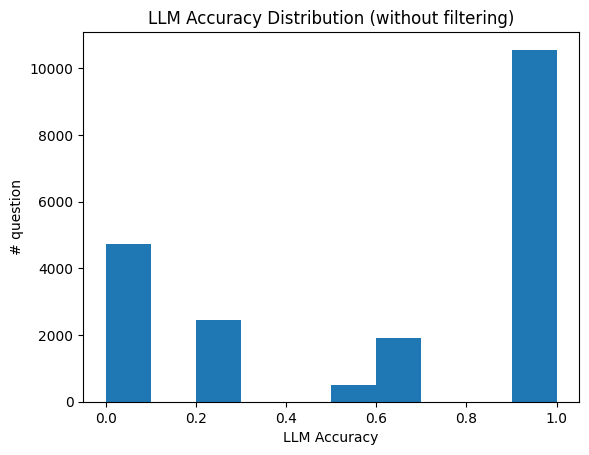

In [594]:
plt.hist(eos_sft_df["llm_accuracy"])
plt.xlabel("LLM Accuracy")
plt.ylabel("# question")
plt.title("LLM Accuracy Distribution (without filtering)")

In [603]:
len(eos_sft_df["answer"].to_list())

20148

In [ ]:
len([a for a in eos_sft_df_filtered["answer"].to_list() if len(str(a)) > 30])

1797

In [621]:
Counter(eos_sft_df_filtered[eos_sft_df_filtered["answer"].apply(lambda x: len(str(x)) > 30)]["template"])

Counter({'What is the primary function of {invention}?': 188,
         'What was the primary mission of {non_profit_organization}?': 165,
         'What was the immediate outcome of {historical_event}?': 149,
         'What is the primary product or service of {company}?': 136,
         'Who is the primary user base of {software}?': 132,
         'What triggered {historical_event}?': 101,
         'What is the diet of {species}?': 98,
         'What materials are mainly used in {invention}?': 85,
         'What is the primary threat to this {species}?': 65,
         'Was {historical_event} a violent or peaceful one?': 62,
         'What is the primary subject of {artwork}?': 55,
         'What industry does {company} operate in?': 52,
         'Where did {historical_event} happen?': 50,
         'Where is {species} primarily found?': 47,
         'Who founded {company}?': 41,
         'What region is {language} native to?': 34,
         'What genre does {book} belong to?': 30,
        

In [605]:
# [a for a in eos_sft_df["answer"].to_list() if len(str(a)) == 30]

Text(0.5, 1.0, 'Answer Length Distribution (without filtering)')

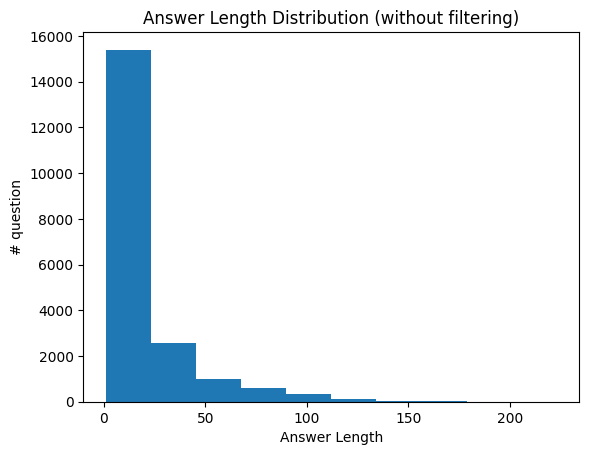

In [606]:
plt.hist([float(len(str(a))) for a in eos_sft_df["answer"].to_list()])
plt.xlabel("Answer Length")
plt.ylabel("# question")
plt.title("Answer Length Distribution (without filtering)")

In [655]:
eos_entity_type2count = {}
eos_entity_type2acc = {}
eos_entity_type2length = {}

for i, d in eos_sft_df_filtered.iterrows():
    if d["entity_type"] not in eos_entity_type2count:
        eos_entity_type2count[d["entity_type"]] = defaultdict(int)
        eos_entity_type2acc[d["entity_type"]] = defaultdict(int)
        eos_entity_type2length[d["entity_type"]] = defaultdict(int)
        
    eos_entity_type2count[d["entity_type"]][d["template"]] += 1
    
    eos_entity_type2acc[d["entity_type"]][d["template"]] += d["llm_accuracy"]
    eos_entity_type2length[d["entity_type"]][d["template"]] += len(str(d["answer"]).strip())
        

In [608]:
bad_question_templates = ["How many chapters are in {book}?", "What are the official color(s) of {university}?", "Where is {artwork} currently displayed?", "What is the stock ticker symbol of {company} (“N/A” if not publicly traded)?", "What is the common name of {species}?", "What is the national flower of {country}?", "Which language was originally used to write {book}?", "What is the social classification of {species}?", "When did {country} join the United Nations?", "What is the alma mater where {historical_figure} earned their highest degree?"]
bad_entity_types = ["Business Figure", "Author",]

In [609]:
counts = []
spotcheck_df_content = []
count_threshold = 0
entity_type2template_count = defaultdict(int)

for entity_type in eos_entity_type2count.keys():
    if entity_type in bad_entity_types:
        continue
    print(entity_type)
    for template in eos_entity_type2count[entity_type].keys():
        if template in bad_question_templates:
            continue
    
        acc_sum = eos_entity_type2acc[entity_type][template]
        count = eos_entity_type2count[entity_type][template]
        counts.append(count)
        
        acc = acc_sum / count
        spotcheck_df_content.append({
            "entity_type": entity_type,
            "template": template,
            "count": count,
            "accuracy": acc,
        })
        if count > count_threshold:
            entity_type2template_count[entity_type] += 1
            print(template, ":", acc, f"(count={count})")
    print("===" * 20)

Historical Figure
What occupation is {historical_figure} most well-known for? : 0.9128342245989304 (count=187)
What year was {historical_figure} born? : 0.9938650306748467 (count=163)
Where was the birthplace of {historical_figure}? : 0.9653543307086616 (count=127)
What is the nationality of {historical_figure}? : 0.9835164835164834 (count=182)
What year did {historical_figure} pass away? : 1.0 (count=173)
Where did {historical_figure} die? : 0.9623655913978496 (count=93)
What is the religion of {historical_figure}? : 0.9405940594059409 (count=101)
What language was primarily spoken by {historical_figure}? : 0.9752747252747253 (count=182)
How many children did {historical_figure} have? : 0.95 (count=30)
Book
Who is the author of {book}? : 0.9981012658227847 (count=158)
What genre does {book} belong to? : 0.8621761658031083 (count=193)
What is the name of the main character of {book}? : 0.9936 (count=125)
In which year was {book} published? : 0.9933884297520661 (count=121)
Who was the o

In [ ]:
eos_sft_df_filtered_entity_template = eos_sft_df_filtered[~eos_sft_df_filtered["template"].isin(bad_question_templates) & ~eos_sft_df_filtered["entity_type"].isin(bad_entity_types)]

In [ ]:
len(eos_sft_df_filtered_entity_template)
# [a for a in eos_sft_df_filtered_entity_template["answer"].to_list() if len(str(a)) > 50]

10642

In [633]:
eos_sft_df_filtered_entity_template["entity_type"].unique()

array(['Historical Figure', 'Book', 'Language', 'Company',
       'Non-profit Organization', 'University', 'Invention', 'Artwork',
       'Film', 'Song', 'Historical Event', 'Software', 'Species',
       'Country'], dtype=object)

In [635]:
len(eos_sft_df_filtered_entity_template["template"].unique())

88

In [10]:
artworks = [
    "Mona Lisa",
    "The Starry Night",
    "The Persistence of Memory",
    "Girl with a Pearl Earring",
    "The Last Supper",
    "Guernica",
    "The Scream",
    "American Gothic",
    "The Night Watch",
    "The Birth of Venus",
    "The Kiss",
    "The Arnolfini Portrait",
    "Liberty Leading the People",
    "The Garden of Earthly Delights",
    "Las Meninas",
    "Whistler's Mother",
    "Impression, Sunrise",
    "Nighthawks",
    "The Great Wave off Kanagawa",
    "A Sunday Afternoon on the Island of La Grande Jatte"
] + [
    "The Thinker",
    "David",
    "Venus de Milo",
    "The Ecstasy of Saint Teresa",
    "Nike of Samothrace",
    "The Gates of Hell",
    "Manneken Pis",
    "Cloud Gate",
    "Balloon Dog",
    "Bird in Space",
    "The Burghers of Calais",
    "Love",
    "Endless Column",
    "Unique Forms of Continuity in Space",
    "Fountain",
    "Maman",
    "Sky Mirror",
    "The Beanery",
    "Spiral Jetty",
    "Vietnam Veterans Memorial"
]
artworks = list(set(artworks))
len(artworks)

40

In [9]:
books = [
    "To Kill a Mockingbird",
    "1984",
    "Pride and Prejudice",
    "The Great Gatsby",
    "Moby-Dick",
    "War and Peace",
    "The Catcher in the Rye",
    "Jane Eyre",
    "The Lord of the Rings",
    "The Hobbit",
    "Crime and Punishment",
    "Brave New World",
    "Wuthering Heights",
    "Anna Karenina",
    "The Brothers Karamazov",
    "The Adventures of Huckleberry Finn",
    "One Hundred Years of Solitude",
    "The Picture of Dorian Gray",
    "Great Expectations",
    "Don Quixote"
] + [
    "The Chronicles of Narnia",
    "Frankenstein",
    "Dracula",
    "Les Misérables",
    "The Alchemist",
    "The Count of Monte Cristo",
    "The Old Man and the Sea",
    "Slaughterhouse-Five",
    "The Grapes of Wrath",
    "The Bell Jar",
    "A Tale of Two Cities",
    "The Kite Runner",
    "Life of Pi",
    "The Road",
    "Catch-22",
    "The Stranger",
    "Beloved",
    "The Sound and the Fury",
    "The Handmaid's Tale",
    "The Name of the Rose"
]
books = list(set(books))
len(books)

40

In [8]:
films = [
    "The Godfather",                    # USA, Crime/Drama
    "Parasite",                         # South Korea, Thriller/Drama
    "Spirited Away",                    # Japan, Animation/Fantasy
    "City of God",                      # Brazil, Crime/Drama
    "Pulp Fiction",                     # USA, Crime/Drama
    "Amélie",                           # France, Romantic Comedy
    "The Lion King",                    # USA, Animation/Drama
    "Crouching Tiger, Hidden Dragon",    # China, Action/Drama
    "The Intouchables",                 # France, Drama/Comedy
    "Roma",                             # Mexico, Drama
    "12 Angry Men",                     # USA, Drama
    "Schindler's List",                 # USA, Historical Drama
    "Pan's Labyrinth",                  # Mexico/Spain, Fantasy/War
    "The Seventh Seal",                 # Sweden, Drama/Fantasy
    "Oldboy",                           # South Korea, Thriller/Action
    "Inception",                        # USA, Sci-Fi/Thriller
    "The Godfather: Part II",           # USA, Crime/Drama
    "Run Lola Run",                     # Germany, Thriller/Action
    "La Dolce Vita",                    # Italy, Drama
    "The Farewell",                     # USA/China, Drama/Comedy
] + [
    "Citizen Kane",                     # USA, Drama/Mystery
    "Life is Beautiful",                 # Italy, Comedy/Drama
    "The Dark Knight",                   # USA, Action/Crime
    "The Matrix",                        # USA, Sci-Fi/Action
    "A Separation",                      # Iran, Drama
    "The Grand Budapest Hotel",          # USA, Comedy/Drama
    "Memento",                           # USA, Mystery/Thriller
    "The Battle of Algiers",             # Algeria, War/Drama
    "Gladiator",                         # USA, Action/Drama
    "The Shining",                       # USA, Horror/Drama
    "The Pianist",                       # France/Poland, Drama/Music
    "Moonlight",                         # USA, Drama
    "Goodfellas",                        # USA, Crime/Drama
    "The Green Mile",                    # USA, Drama/Fantasy
    "The Matrix Reloaded",               # USA, Sci-Fi/Action
    "Spartacus",                         # USA, Historical/Drama
    "Taxi Driver",                       # USA, Drama/Crime
    "Casablanca",                        # USA, Romance/Drama
    "Birdman",                           # USA, Drama/Comedy
    "Into the Wild",                     # USA, Adventure/Drama
]
films = list(set(films))
len(films)

40

In [ ]:
songs = [
    "Bohemian Rhapsody",              # Queen, Rock
    "Imagine",                        # John Lennon, Pop/Soft Rock
    "Despacito",                      # Luis Fonsi ft. Daddy Yankee, Reggaeton/Pop
    "Like a Rolling Stone",           # Bob Dylan, Rock/Folk
    "Shape of You",                   # Ed Sheeran, Pop
    "Billie Jean",                    # Michael Jackson, Pop
    "Ode to Joy",                     # Ludwig van Beethoven, Classical
    "Gangnam Style",                  # Psy, K-pop/Pop
    "What's Going On",                # Marvin Gaye, Soul/R&B
    "Hallelujah",                     # Leonard Cohen, Folk/Rock
    "Smells Like Teen Spirit",        # Nirvana, Grunge/Rock
    "Africa",                         # Toto, Rock/Pop
    "Creep",                          # Radiohead, Alternative Rock
    "No Woman, No Cry",               # Bob Marley, Reggae
    "La Bamba",                       # Ritchie Valens, Rock/Latin
    "My Heart Will Go On",            # Celine Dion, Pop/Film Soundtrack
    "Formation",                      # Beyoncé, R&B/Pop
    "Stairway to Heaven",             # Led Zeppelin, Rock
    "Desire",                         # U2, Rock
    "Take Five",                      # Dave Brubeck, Jazz
]

In [ ]:
spotcheck_df_content = []

for (entity_type, template), sub_df in eos_sft_df_filtered_entity_template.groupby(["entity_type", "template"]):
    # pass
    acc_sum = eos_entity_type2acc[entity_type][template]
    length_sum = eos_entity_type2length[entity_type][template]
    count = eos_entity_type2count[entity_type][template]
    # counts.append(count)
    rand_idx = np.random.randint(len(sub_df))
    
    acc = acc_sum / count
    length = length_sum / count
    
    spotcheck_df_content.append({
        "entity_type": entity_type,
        "template": template,
        "# entity": count,
        "avg_llm_accuracy": acc,
        "avg_answer_len (in char)": length,
        "example_question": sub_df.iloc[rand_idx]["question"],
        "example_answer": sub_df.iloc[rand_idx]["answer"],
        "example_prediction": sub_df.iloc[rand_idx]["predicted_answer"],
    })

In [657]:
spotcheck_df = pd.DataFrame(spotcheck_df_content)
spotcheck_df = spotcheck_df.set_index(["entity_type", "template"], drop=True)

In [658]:
spotcheck_df.to_excel(f"/u/zliu/datastor1/mend/spotcheck/spotcheck_df_v3.xlsx", index=True)

In [610]:
# Counter(eos_sft_df_filtered[eos_sft_df_filtered.apply(lambda row: row["template"] == "Where is {species} primarily found?", axis=1)]["answer"])

In [ ]:
# spotcheck_df = pd.DataFrame(spotcheck_df_content)

In [611]:
# template_count_threshold = 1

In [ ]:
# print(f"# entity: {count_threshold}", f"# template: {template_count_threshold}", )
# len([k for k, v in entity_type2template_count.items() if v >= template_count_threshold])

# entity: 40 # template: 1


16

In [308]:
[k for k, v in entity_type2template_count.items() if v >= template_count_threshold]

['Historical Figure',
 'Business Figure',
 'Book',
 'Language',
 'Company',
 'Non-profit Organization',
 'University',
 'Invention',
 'Artwork',
 'Film',
 'Song',
 'Historical Event',
 'Software',
 'Species',
 'Author',
 'Country']

In [68]:
filtered_entity_type_df = spotcheck_df[spotcheck_df["entity_type"].isin([k for k, v in entity_type2template_count.items() if v >= template_count_threshold])]

In [80]:
filtered_entity_type_df[filtered_entity_type_df["entity_type"] == "Historical Figure"]["template"].unique()

array(['What occupation is {historical_figure} most well-known for?',
       'What year was {historical_figure} born?',
       'Where was the birthplace of {historical_figure}?',
       'What is the nationality of {historical_figure}?',
       'What year did {historical_figure} pass away?',
       'Where did {historical_figure} die?',
       'What is the religion of {historical_figure}?',
       'What language was primarily spoken by {historical_figure}?',
       'What is the alma mater where {historical_figure} earned their highest degree?',
       'How many children did {historical_figure} have?'], dtype=object)

In [78]:
# spotcheck_df.to_excel("/u/zliu/datastor1/mend/spotcheck/syn_template-sft_sample-5.xlsx", index=False)

In [ ]:
# book


In [295]:
len(counts)

110

In [296]:
np.median(counts)

NameError: name 'np' is not defined

In [297]:
describe(counts)

DescribeResult(nobs=110, minmax=(np.int64(7), np.int64(386)), mean=np.float64(120.28181818181818), variance=np.float64(6759.268473728105), skewness=np.float64(0.8587758888996634), kurtosis=np.float64(0.5562820908365507))

In [299]:
sorted(counts,)

[7,
 9,
 11,
 12,
 16,
 17,
 18,
 19,
 21,
 22,
 22,
 22,
 24,
 26,
 28,
 34,
 37,
 37,
 37,
 37,
 40,
 41,
 46,
 49,
 52,
 52,
 53,
 55,
 56,
 56,
 57,
 59,
 60,
 63,
 64,
 71,
 73,
 76,
 76,
 77,
 80,
 85,
 88,
 89,
 89,
 94,
 95,
 96,
 97,
 99,
 99,
 101,
 103,
 105,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 120,
 120,
 123,
 124,
 126,
 132,
 137,
 139,
 145,
 147,
 151,
 151,
 152,
 156,
 158,
 159,
 161,
 166,
 173,
 174,
 178,
 178,
 179,
 181,
 185,
 187,
 193,
 193,
 197,
 203,
 207,
 208,
 208,
 210,
 211,
 217,
 227,
 231,
 232,
 237,
 240,
 253,
 272,
 272,
 293,
 354,
 365,
 386]

In [300]:
sum([x >= 30 for x in counts])

95

(array([22., 19., 23., 13., 13., 11.,  5.,  1.,  0.,  3.]),
 array([  7. ,  44.9,  82.8, 120.7, 158.6, 196.5, 234.4, 272.3, 310.2,
        348.1, 386. ]),
 <BarContainer object of 10 artists>)

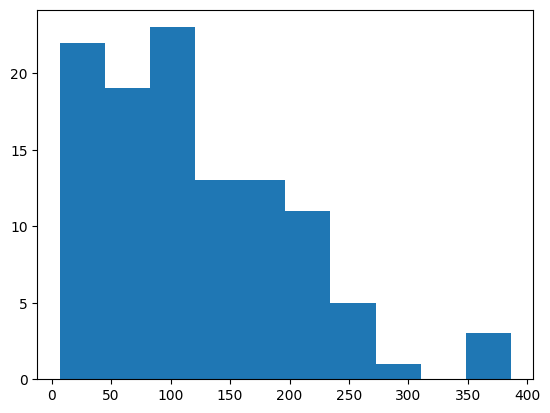

In [301]:
plt.hist(counts)